In [1]:
import imgaug.augmenters as iaa
import os
import cv2
import numpy as np

# Set your dataset directories
normal_dir = '/kaggle/input/net-pothole-data/normal'
potholes_dir = '/kaggle/input/net-pothole-data/potholes'
output_dir_normal = '/kaggle/working/augmented/normal'
output_dir_potholes = '/kaggle/working/augmented/potholes'

# Create directories to save augmented images
os.makedirs(output_dir_normal, exist_ok=True)
os.makedirs(output_dir_potholes, exist_ok=True)

# Define the augmentation pipeline
aug_pipeline = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Affine(rotate=(-45, 45)),  # Rotate between -45 and 45 degrees
    iaa.Multiply((0.7, 1.3)),  # Change brightness
    iaa.GaussianBlur(sigma=(0, 1.5))  # Apply gaussian blur
])

def augment_images(input_dir, output_dir, target_count=1500):
    image_files = [f for f in os.listdir(input_dir) if f.endswith('.jpg') or f.endswith('.png')]
    count = 0

    while count < target_count:
        for img_file in image_files:
            # Read the image
            img_path = os.path.join(input_dir, img_file)
            image = cv2.imread(img_path)
            
            # Check if the image was read successfully
            if image is None:
                print(f"Warning: Could not read image {img_file}. Skipping.")
                continue  # Skip to the next image

            # Perform augmentations
            image_aug = aug_pipeline(image=image)

            # Save the augmented image
            new_img_name = f"aug_{count}_{img_file}"
            cv2.imwrite(os.path.join(output_dir, new_img_name), image_aug)

            count += 1
            if count >= target_count:
                break

# Augment normal and potholes images
augment_images(normal_dir, output_dir_normal, target_count=1500)
augment_images(potholes_dir, output_dir_potholes, target_count=1500)

print("Augmentation complete!")


Augmentation complete!


In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import cv2
import imghdr

In [6]:
data_dir = '/kaggle/working/augmented' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
print("Done")

Done


In [7]:
pip install tqdm


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
import cv2
import imghdr
from tqdm import tqdm.notebook

# Assuming data_dir and image_exts are already defined
# data_dir = 'your/data/directory'
# image_exts = ['jpg', 'jpeg', 'png', 'bmp', ...]

image_classes = os.listdir(data_dir)

# Use tqdm to display a progress bar
for image_class in tqdm(image_classes, desc="Processing Classes"):
    class_path = os.path.join(data_dir, image_class)
    images = os.listdir(class_path)
    
    for image in tqdm(images, desc=f"Processing {image_class}", leave=False):
        image_path = os.path.join(class_path, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f'Image not in ext list {image_path}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with image {image_path}')
            # os.remove(image_path)


Processing Classes: 100%|██████████| 2/2 [00:19<00:00,  9.73s/it]        


**3. Load Data**

In [9]:
import numpy as np
from matplotlib import pyplot as plt
print("Joker")

Joker


In [10]:
data = tf.keras.utils.image_dataset_from_directory('/kaggle/working/augmented')

Found 3000 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

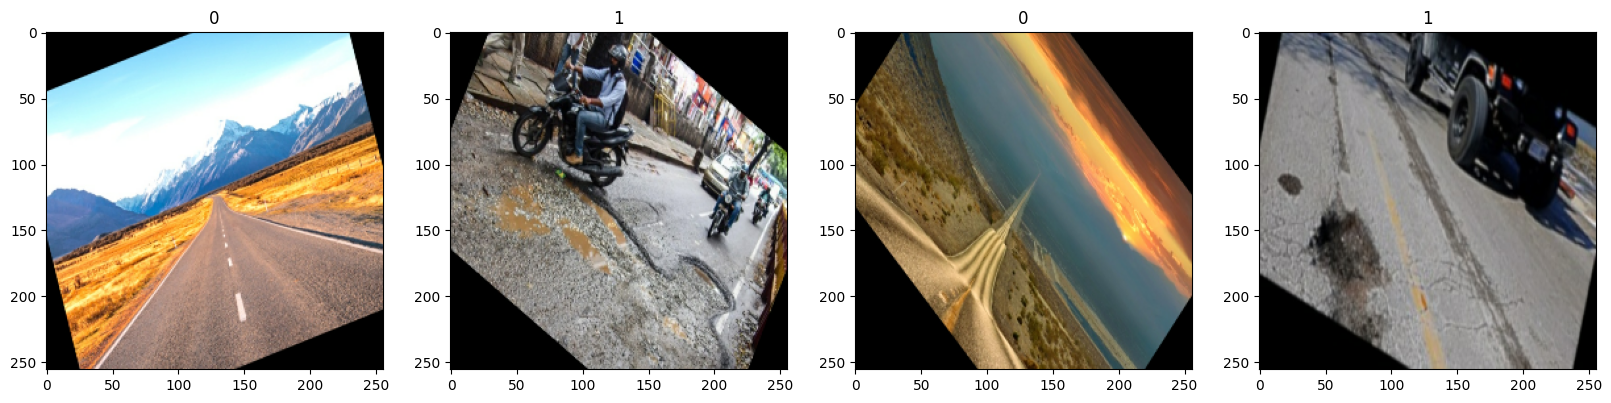

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

**4. Scale Data**

In [14]:
data = data.map(lambda x,y: (x/255, y))

In [15]:
data.as_numpy_iterator().next()
print("Done")

Done


**5. Split Data**

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)
len(test)

10

**6. Building Model**

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [19]:
model = Sequential()

In [20]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from keras.models import Sequential

model = Sequential()

# Add an Input layer to specify the input shape
model.add(Input(shape=(256, 256, 3)))

# The rest of the model layers remain unchanged
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [21]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

**7. Train**

In [23]:
logdir='logs'

In [24]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [25]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


I0000 00:00:1731237813.105179     115 service.cc:145] XLA service 0x7cf738002030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731237813.105239     115 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731237816.856015     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 0.5555 - loss: 0.7671 - val_accuracy: 0.8766 - val_loss: 0.3401
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.8706 - loss: 0.3102 - val_accuracy: 0.9145 - val_loss: 0.2183
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.8899 - loss: 0.2788 - val_accuracy: 0.8849 - val_loss: 0.2759
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.9146 - loss: 0.2228 - val_accuracy: 0.9194 - val_loss: 0.1795
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - accuracy: 0.9329 - loss: 0.1583 - val_accuracy: 0.9194 - val_loss: 0.2018
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.9527 - loss: 0.1181 - val_accuracy: 0.9309 - val_loss: 0.1651
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9578 - loss: 0.1188 - val_accuracy: 0.9359 - val_loss: 0.1621
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 241ms/step - accuracy: 0.9673 - loss: 0.0909 - val_accuracy: 0.919

In [26]:
from keras.models import Sequential
import os

# Save the model to an .h5 file
model.save('my_model.h5')

# Check if the file is saved correctly
assert os.path.exists('my_model.h5'), "Error: Model file not saved!"

# Generate a download link
from IPython.display import FileLink

# Display the download link
FileLink(r'my_model.h5')

/kaggle/working/my_model.h5

**Plotting Performance**

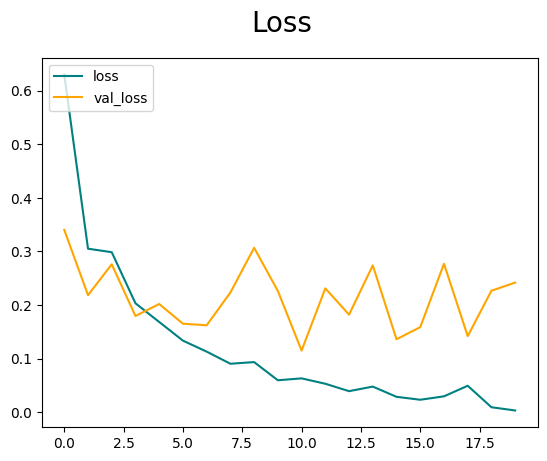

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

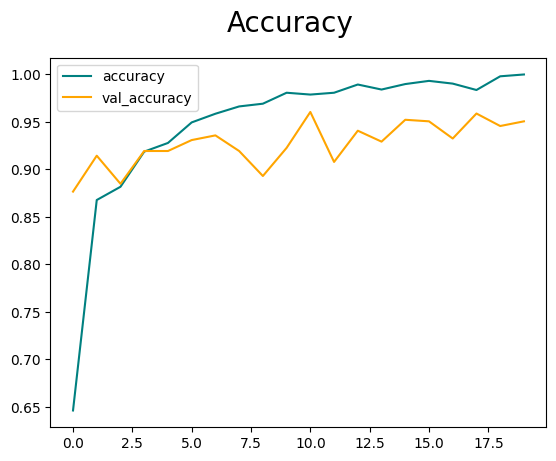

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [30]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


In [32]:
print(f"Precision = {pre.result().numpy():.4f}")
print(f"Recall = {re.result().numpy():.4f}")
print(f"Accuracy = {acc.result().numpy():.4f}")

Precision = 0.8793
Recall = 0.9684
Accuracy = 0.9167


In [33]:
import cv2

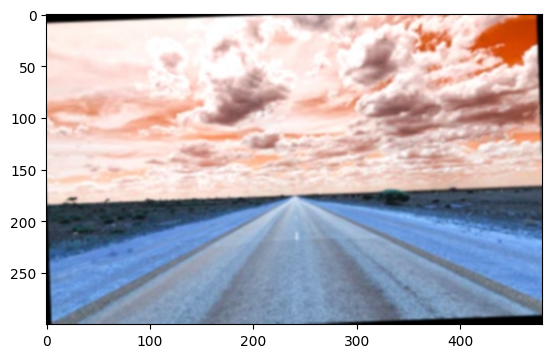

In [41]:
img = cv2.imread('/kaggle/working/augmented/normal/aug_310_303.jpg')
plt.imshow(img)
plt.show()

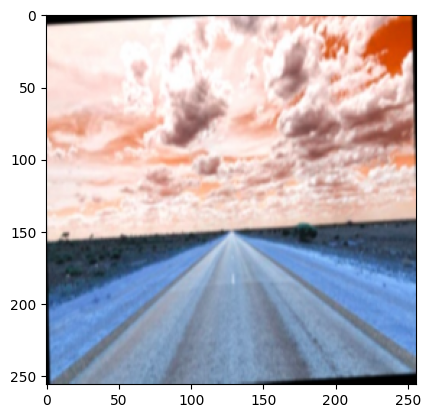

In [42]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [43]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [44]:
yhat

array([[1.4237199e-08]], dtype=float32)

In [46]:
print(yhat)

[[1.4237199e-08]]


In [45]:
if yhat > 0.5: 
    print(f'Pothole Detected')
else:
    print(f'Smooth Road')

Smooth Road
